In [1]:
import pandas as pd
import pickle
import faiss
import numpy as np
import joblib
import torch
import random


In [151]:
books_list = []
with open('../Pickle/books.pkl', 'rb') as file:
    while True:
        try:
            books_list.append(pickle.load(file))
        except EOFError:
            break
books = pd.concat(books_list, ignore_index=True).drop_duplicates(subset='title', keep='first')


In [3]:
interactions = pd.read_pickle('../Pickle/interactions.pkl')
read = pd.read_pickle('../Pickle/read.pkl')
reviews = pd.read_pickle('../Pickle/reviews.pkl')

In [4]:
interaction = interactions[interactions['rating'] != 0]
read = read[read['rating'] != 0]
reviews = reviews[reviews['rating'] != 0]

In [5]:
umap_embeddings = pd.read_pickle('../Pickle/umap_embeddings.pkl')
faiss_index = faiss.read_index('../Pickle/faiss_index.bin')
book_id_to_index = pd.read_pickle('../Pickle/book_id_to_index.pkl')
user_id_to_index_gat = pd.read_pickle('../Pickle/user_id_to_index_gat.pkl')
book_id_to_index_gat = pd.read_pickle('../Pickle/book_id_to_index_gat.pkl')
all_embeddings = pd.read_pickle('../Pickle/gat_embeddings.pkl')
clustered_books = pd.read_pickle('../Pickle/clustered_books.pkl')

In [6]:
def denormalize_rating(log_scaled_ratings, min_rating):
    log_scaled_ratings = np.asarray(log_scaled_ratings, dtype=float)
    original_ratings = np.expm1(log_scaled_ratings)
    if min_rating:
        original_ratings += min_rating
    return np.clip(original_ratings, 0, 5)

In [7]:
def load_gat_model():
    from Gatv2Conv import GATModel
    model = GATModel(
        in_channels=32,
        hidden_channels=30,
        out_channels=1,
        num_heads=25,
        edge_feature_dim=386
    )
    model.load_state_dict(torch.load('../Pickle/gat_model.pth'))
    model.eval()
    return model

In [8]:
import joblib
def load_nmf_model_with_joblib(joblib_file_path):
    return joblib.load(joblib_file_path)
joblib_file_path = '../Pickle/best_nmf_model.pkl' 
nmf_model = load_nmf_model_with_joblib(joblib_file_path)

In [9]:
def recommend_HDBSCAN_new_user(clustered_books, faiss_index, books, top_n=5, cluster_threshold=0.1, random_cluster_count=3):
    all_clusters = {cluster_id for row in clustered_books.itertuples() for cluster_id, prob in row.top_clusters}
    
    sampled_clusters = random.sample(sorted(all_clusters), min(random_cluster_count, len(all_clusters)))

    relevant_books = []
    embeddings = []
    book_ids = []

    for row in clustered_books.itertuples():
        shared_clusters = {cid for cid, prob in row.top_clusters if cid in sampled_clusters and prob >= cluster_threshold}
        if shared_clusters:
            relevant_books.append(row.book_id)
            embeddings.append(np.array(row.embedding).astype('float32'))
            book_ids.append(row.book_id)

    if relevant_books:
        embeddings = np.array(embeddings)
        distances = np.linalg.norm(embeddings, axis=1)
        sorted_indices = np.argsort(distances)

        recommendations = []
        for idx in sorted_indices[:top_n]:
            book_id = book_ids[idx]
            book_info = books.loc[books['book_id'] == book_id].iloc[0]
            title, authors = book_info['title'], book_info['authors']
            similarity_score = 1 / (1 + distances[idx])
            recommendations.append({
                "Book ID": book_id,
                "Title": title,
                "Authors": authors,
                "Similarity Score": round(similarity_score, 4)
            })
        
        return recommendations

    if faiss_index is not None:
        print("No relevant books found in random clusters. Falling back to FAISS global search.")
        random_book = random.choice(clustered_books['book_id'].values)
        book_row = clustered_books[clustered_books['book_id'] == random_book].iloc[0]
        query_embedding = np.array(book_row['embedding']).astype('float32').reshape(1, -1)
        D, I = faiss_index.search(query_embedding, top_n + 1)

        recommendations = []
        for idx in I[0]:
            similar_book_id = clustered_books.iloc[idx]['book_id']
            if similar_book_id == random_book:
                continue
            distance = D[0][np.where(I[0] == idx)[0][0]]
            similarity_score = 1 / (1 + distance)

            book_info = books.loc[books['book_id'] == similar_book_id].iloc[0]
            title, authors = book_info['title'], book_info['authors']
            
            recommendations.append({
                "Book ID": similar_book_id,
                "Title": title,
                "Authors": authors,
                "Similarity Score": round(similarity_score, 4)
            })

            if len(recommendations) == top_n:
                break
        
        return recommendations

    print("No relevant books found from either method. Returning default fallback recommendations.")
    
    random_books = random.sample(clustered_books['book_id'].values.tolist(), top_n)
    recommendations = []
    for book_id in random_books:
        book_info = books.loc[books['book_id'] == book_id].iloc[0]
        title = book_info['title']
        authors = book_info['authors']
        recommendations.append({
            "Book ID": book_id,
            "Title": title,
            "Authors": authors,
            "Similarity Score": 'N/A'
        })
    
    return recommendations


In [10]:
def recommend_HDBSCAN(book_id, clustered_books, faiss_index, books, top_n=5, cluster_threshold=0.1):
    if book_id not in clustered_books['book_id'].values:
        print(f"Book ID {book_id} not found.")
        return []
    
    book_row = clustered_books[clustered_books['book_id'] == book_id].iloc[0]
    query_embedding = np.array(book_row['embedding']).astype('float32')
    top_clusters = dict(book_row['top_clusters'])

    clustered_books['shared_clusters'] = clustered_books['top_clusters'].apply(lambda clusters: 
        [cid for cid, prob in clusters if cid in top_clusters and prob >= cluster_threshold])

    relevant_books = clustered_books[clustered_books['shared_clusters'].apply(len) > 0]

    if not relevant_books.empty:
        embeddings = np.array(relevant_books['embedding'].tolist())
        distances = np.linalg.norm(embeddings - query_embedding, axis=1)

        sorted_indices = np.argsort(distances)

        recommendations = []
        for idx in sorted_indices[:top_n]:
            book_id = relevant_books.iloc[idx]['book_id']
            book_info = books[books['book_id'] == book_id].iloc[0]
            title = book_info['title']
            authors = book_info['authors']
            recommendations.append({
                'book_id': book_id,
                'title': title,
                'authors': authors,
                'similarity_score': round(1 / (1 + distances[idx]), 3)
            })

        return recommendations
    
    if faiss_index is not None:
        print("No relevant books found in top clusters. Falling back to FAISS global search.")
        query_embedding = query_embedding.reshape(1, -1)
        D, I = faiss_index.search(query_embedding, top_n + 1)
        
        recommendations = []
        for idx in I[0]:
            similar_book_id = clustered_books.iloc[idx]['book_id']
            if similar_book_id == book_id:
                continue
            distance = D[0][np.where(I[0] == idx)[0][0]]
            similarity_score = round(1 / (1 + distance), 3)

            book_info = books[books['book_id'] == similar_book_id].iloc[0]
            title = book_info['title']
            authors = book_info['authors']
            
            recommendations.append({
                'book_id': similar_book_id,
                'title': title,
                'authors': authors,
                'similarity_score': similarity_score
            })

            if len(recommendations) == top_n:
                break
        
        return recommendations

    print("No recommendations found.")
    return []


In [11]:
def recommend_nmf(
    nmf_model, 
    interactions, 
    user_id, 
    books_read, 
    books, 
    min_rating, 
    n_recommendations=5, 
    top_n_factors=1,
):
    all_books = interactions['book_id'].unique()
    candidate_books = [book_id for book_id in all_books if book_id not in books_read]

    user_predictions = [
        (book_id, nmf_model.predict(uid=user_id, iid=book_id).est)
        for book_id in candidate_books
    ]
    
    top_books = sorted(user_predictions, key=lambda x: x[1], reverse=True)[:n_recommendations]
    
    user_inner_id = nmf_model.trainset.to_inner_uid(user_id)
    pu = nmf_model.pu
    qi = nmf_model.qi
    user_factors = pu[user_inner_id]

    recommendations_with_explanations = []

    for book_id, raw_pred_rating in top_books:
        try:
            item_inner_id = nmf_model.trainset.to_inner_iid(book_id)
        except ValueError:
            continue
        
        item_factors = qi[item_inner_id]

        contributions = user_factors * item_factors
        predicted_rating = contributions.sum()

        top_factors_idx = np.argsort(np.abs(contributions))[::-1][:top_n_factors]

        book_title = books.loc[books['book_id'] == book_id, 'title'].values[0]
        
        denormed_rating = denormalize_rating([predicted_rating], min_rating)[0]

        explanations = []
        
        for rank, i in enumerate(top_factors_idx, 1):
            explanation = {
                'latent_factor': int(i + 1),
                'user_affinity': round(user_factors[i], 3),
                'item_relevance': round(item_factors[i], 3),
                'contribution': round(contributions[i], 3)
            }
            explanations.append(explanation)

        recommendations_with_explanations.append({
            'book_id': book_id,
            'title': book_title,
            'predicted_rating': round(denormed_rating, 2),
            'top_latent_factors': explanations
        })

    return recommendations_with_explanations


In [ ]:
def recommend_GAT(user_id, unread_book_ids, all_embeddings, user_id_to_index, book_id_to_index, books_df, min_rating, top_n=5):
    user_index = user_id_to_index.get(user_id)
    if user_index is None:
        raise ValueError(f"User ID {user_id} not found in index mappings.")

    user_embedding = all_embeddings[user_index]

    predictions = []

    for book_id in unread_book_ids:
        book_index = book_id_to_index.get(book_id)
        if book_index is None:
            continue

        book_embedding = all_embeddings[book_index]

        predicted_rating = np.expm1(np.dot(user_embedding, book_embedding))

        denormed_rating = denormalize_rating([predicted_rating], min_rating)[0] if min_rating else predicted_rating

        book_title = books_df.loc[books_df['book_id'] == book_id, 'title'].values[0] if 'book_id' in books_df.columns else None

        predictions.append({
            "book_id": book_id,
            "title": book_title,
            "predicted_rating": denormed_rating
        })

    sorted_books = sorted(predictions, key=lambda x: x["predicted_rating"], reverse=True)

    return sorted_books[:top_n]



In [13]:
def merge_recommendations_ranked(gat_recs, nmf_recs, books_df, final_size, gat_weight = 0.4, nmf_weight = 0.6):
    gat_recs_sorted = sorted(gat_recs, key=lambda x: x['predicted_rating'], reverse=True)
    nmf_recs_sorted = sorted(nmf_recs, key=lambda x: x['predicted_rating'], reverse=True)

    combined_recs = []
    seen_books = set()

    for rank, rec in enumerate(gat_recs_sorted, start=1):
        if rec['book_id'] not in seen_books:
            combined_recs.append({
                'book_id': rec['book_id'],
                'rank': rank,
                'score': gat_weight * rank,
                'predicted_rating': rec['predicted_rating']
            })
            seen_books.add(rec['book_id'])

    for rank, rec in enumerate(nmf_recs_sorted, start=1):
        if rec['book_id'] not in seen_books:
            combined_recs.append({
                'book_id': rec['book_id'],
                'rank': rank,
                'score': nmf_weight * rank,
                'predicted_rating': rec['predicted_rating']
            })
            seen_books.add(rec['book_id'])

    combined_recs.sort(key=lambda x: x['score'])

    final_recs = []
    for rec in combined_recs:
        if len(final_recs) < final_size:
            book_id = rec['book_id']
            book_title = books_df.loc[books_df['book_id'] == book_id, 'title'].values[0]
            final_recs.append({
                'book_id': book_id,
                'title': book_title,
                'predicted_rating': rec['predicted_rating'],
            })
        else:
            break

    return final_recs

In [14]:
valid_books = set(books['book_id'])
reviews = reviews[reviews['book_id'].isin(valid_books)].copy()
interactions = interactions[interactions['book_id'].isin(valid_books)].copy()

In [15]:
def get_user_stats(user_id, interactions, reviews):
    books_read = interactions[interactions['user_id'] == user_id]['book_id'].nunique()
    reviews_written = reviews[reviews['user_id'] == user_id].shape[0]
    return books_read, reviews_written


def recommend_for_user(user_id, interactions, reviews, faiss_index, book_id_to_index, clustered_books, nmf_model, all_embeddings, user_id_to_index_gat, book_id_to_index_gat, books, min_rating, top_n=5, final_size=5, gat_weight=0.6, nmf_weight=0.5):
    books_read, reviews_written = get_user_stats(user_id, interactions, reviews)
    print(f"User {user_id} stats: {books_read} books rated, {reviews_written} reviews written.")
    
    if books_read == 0:
        print(f"User {user_id}: New user, no books rated. Using random content-based recommendations")
        recommendations = recommend_HDBSCAN_new_user(clustered_books, faiss_index, books, top_n)
        return recommendations

    elif books_read <= 5:
        print(f"User {user_id}: Less than 10 books rated, using HDBSCAN-based recommendations")
        books_read_list = interactions[interactions['user_id'] == user_id]['book_id'].unique()
        all_recommendations = []

        for book_id in books_read_list:
            recommendations = recommend_HDBSCAN(book_id, clustered_books, faiss_index, books, top_n=5) 
            if recommendations:
                all_recommendations.extend(recommendations)

        seen_books = set()
        unique_recommendations = []
        for rec in all_recommendations:
            if rec['book_id'] not in seen_books:
                seen_books.add(rec['book_id'])
                unique_recommendations.append(rec)

        unique_recommendations.sort(key=lambda x: x['similarity_score'], reverse=True)
        unique_recommendations = unique_recommendations[:5]
        return unique_recommendations

    elif books_read > 5 and reviews_written <= 5:
        print(f"User {user_id}: More than 5 books rated but less than 6 reviews, using NMF-based recommendations")
        unread_books = interactions[interactions['user_id'] == user_id]['book_id'].unique()
        recommendations = recommend_nmf(nmf_model, interactions, user_id, unread_books, books, min_rating, top_n)
        return recommendations

    elif books_read > 5 and reviews_written > 5:
        print(f"User {user_id}: More than 5 books rated and more than 5 reviews, using combined NMF + GAT recommendations")
        unread_books = interactions[interactions['user_id'] == user_id]['book_id'].unique()
        nmf_recs = recommend_nmf(nmf_model, interactions, user_id, unread_books, books, min_rating, top_n)
        gat_recs = recommend_GAT(user_id, unread_books, all_embeddings, user_id_to_index_gat, book_id_to_index_gat, books, min_rating, top_n)
        recommendations = merge_recommendations_ranked(gat_recs, nmf_recs, books, final_size, gat_weight, nmf_weight)
        return recommendations

    return []


In [16]:
user_counts = interactions['user_id'].value_counts()
valid_user_ids = user_counts[(user_counts == 100)].index
filtered_interactions = interactions[interactions['user_id'].isin(valid_user_ids)]


In [17]:
def generate_recs_hybrid(interactions, reviews, faiss_index, book_id_to_index, 
                                          clustered_books, nmf_model, all_embeddings, user_id_to_index_gat, 
                                          book_id_to_index_gat, books, min_rating=1, top_n=5, 
                                          final_size=5, gat_weight=0.6, nmf_weight=0.4):
    """
    Generates recommendations for eligible users without merging true ratings.
    
    Args:
    interactions (pd.DataFrame): User-item interaction data.
    reviews (pd.DataFrame): User reviews data.
    faiss_index (Index): FAISS index for fast nearest neighbor search.
    book_id_to_index (dict): Mapping of book IDs to indices.
    clustered_books (dict): Predefined clusters of books.
    nmf_model (model): Pre-trained NMF model for recommendation.
    all_embeddings (dict): Book embeddings for recommendation.
    user_id_to_index_gat (dict): Mapping of user IDs to indices for GAT model.
    book_id_to_index_gat (dict): Mapping of book IDs to indices for GAT model.
    books (pd.DataFrame): DataFrame containing book information.
    min_rating (int): Minimum rating threshold for valid recommendations.
    top_n (int): Number of top recommendations to generate.
    final_size (int): Final number of recommendations to return.
    gat_weight (float): Weight for GAT-based recommendations.
    nmf_weight (float): Weight for NMF-based recommendations.
    
    Returns:
    pd.DataFrame: DataFrame with recommendations.
    """
    interactions_count = interactions['user_id'].value_counts()
    reviews_count = reviews['user_id'].value_counts()

    eligible_users = interactions_count.reindex(reviews_count.index, fill_value=0)
    eligible_users = eligible_users[(eligible_users > 5) & (reviews_count > 5)].index
    eligible_users_gat = [user_id for user_id in eligible_users if user_id in user_id_to_index_gat]
    print(f"Eligible users : {len(eligible_users_gat)}")
    recommendations = []
    for user_id in eligible_users_gat:
        recs = recommend_for_user(
            user_id, interactions, reviews, faiss_index, book_id_to_index, clustered_books, 
            nmf_model, all_embeddings, user_id_to_index_gat, book_id_to_index_gat, books, 
            min_rating=min_rating, top_n=top_n, final_size=final_size, gat_weight=gat_weight, nmf_weight=nmf_weight
        )
        
        for rec in recs:
            recommendations.append({'user_id': user_id, **rec})  
        
        print(f"Recommendations for user {user_id}: {recs}")
    
    print(f"Recommendations list size: {len(recommendations)}")
    df_recommendations = pd.DataFrame(recommendations)
    return df_recommendations


In [18]:
def generate_recs_nmf(interactions, reviews, faiss_index, book_id_to_index, 
                      clustered_books, nmf_model, all_embeddings, user_id_to_index_gat, 
                      book_id_to_index_gat, books, min_rating=1, top_n=5, 
                      final_size=5, gat_weight=0.6, nmf_weight=0.4):
    """
    Generates recommendations for eligible users without merging true ratings.
    
    Args:
    interactions (pd.DataFrame): User-item interaction data.
    reviews (pd.DataFrame): User reviews data.
    faiss_index (Index): FAISS index for fast nearest neighbor search.
    book_id_to_index (dict): Mapping of book IDs to indices.
    clustered_books (dict): Predefined clusters of books.
    nmf_model (model): Pre-trained NMF model for recommendation.
    all_embeddings (dict): Book embeddings for recommendation.
    user_id_to_index_gat (dict): Mapping of user IDs to indices for GAT model.
    book_id_to_index_gat (dict): Mapping of book IDs to indices for GAT model.
    books (pd.DataFrame): DataFrame containing book information.
    min_rating (int): Minimum rating threshold for valid recommendations.
    top_n (int): Number of top recommendations to generate.
    final_size (int): Final number of recommendations to return.
    gat_weight (float): Weight for GAT-based recommendations.
    nmf_weight (float): Weight for NMF-based recommendations.
    
    Returns:
    pd.DataFrame: DataFrame with recommendations.
    """
    interactions_count = interactions['user_id'].value_counts()
    reviews_count = reviews['user_id'].value_counts()

    eligible_users = interactions_count.reindex(reviews_count.index, fill_value=0)
    eligible_users = eligible_users[(eligible_users > 5) & (reviews_count <= 5)].index
    print(f"Eligible users: {len(eligible_users)}")

    recommendations = []
    
    for user_id in eligible_users:
        books_read = interactions[interactions['user_id'] == user_id]['book_id'].nunique()
        reviews_written = reviews[reviews['user_id'] == user_id].shape[0]
        
        if books_read > 5 and reviews_written <= 5:
            print(f"User {user_id}: More than 5 books rated but less than or equal to 5 reviews, using NMF-based recommendations.")
            unread_books = interactions[interactions['user_id'] == user_id]['book_id'].unique()
            recs = recommend_nmf(nmf_model, interactions, user_id, unread_books, books, min_rating, top_n)
            
            for rec in recs:
                recommendations.append({'user_id': user_id, **rec}) 
            
        else:
            recs = recommend_for_user(
                user_id, interactions, reviews, faiss_index, book_id_to_index, clustered_books, 
                nmf_model, all_embeddings, user_id_to_index_gat, book_id_to_index_gat, books, 
                min_rating=min_rating, top_n=top_n, final_size=final_size, gat_weight=gat_weight, nmf_weight=nmf_weight
            )
            
            for rec in recs:
                recommendations.append({'user_id': user_id, **rec})  
        print(f"Recommendations for user {user_id}: {recs}")
        print(f"Recommendations list size: {len(recommendations)}")
    df_recommendations = pd.DataFrame(recommendations)
    return df_recommendations


In [19]:
def generate_recs_gat(interactions, reviews, faiss_index, book_id_to_index, 
                      clustered_books, nmf_model, all_embeddings, user_id_to_index_gat, 
                      book_id_to_index_gat, books, min_rating=1, top_n=5, 
                      final_size=5, gat_weight=0.6, nmf_weight=0.4):
    """
    Generates recommendations for eligible users using GAT-based recommendations only.
    
    Args:
    interactions (pd.DataFrame): User-item interaction data.
    reviews (pd.DataFrame): User reviews data.
    faiss_index (Index): FAISS index for fast nearest neighbor search.
    book_id_to_index (dict): Mapping of book IDs to indices.
    clustered_books (dict): Predefined clusters of books.
    nmf_model (model): (Unused here) Pre-trained NMF model for recommendation.
    all_embeddings (dict): Book and user embeddings for recommendation.
    user_id_to_index_gat (dict): Mapping of user IDs to indices for GAT model.
    book_id_to_index_gat (dict): Mapping of book IDs to indices for GAT model.
    books (pd.DataFrame): DataFrame containing book information.
    min_rating (int): Minimum rating threshold for valid recommendations.
    top_n (int): Number of top recommendations to generate.
    final_size (int): Final number of recommendations to return (unused here).
    gat_weight (float): (Unused here)
    nmf_weight (float): (Unused here)
    
    Returns:
    pd.DataFrame: DataFrame with GAT-based recommendations.
    """

    # Count user interactions and reviews
    interactions_count = interactions['user_id'].value_counts()
    reviews_count = reviews['user_id'].value_counts()

    # Define eligible users (based on interactions + reviews count)
    eligible_users = interactions_count.reindex(reviews_count.index, fill_value=0)
    eligible_users = eligible_users[(eligible_users > 5) & (reviews_count > 6)].index
    print(f"Eligible users: {len(eligible_users)}")

    recommendations = []
    
    for user_id in eligible_users:
        print(f"Generating GAT-based recommendations for user {user_id}...")

        # Get books the user has read (to exclude)
        unread_books = interactions[interactions['user_id'] == user_id]['book_id'].unique()

        # Call recommend_GAT for each eligible user
        recs = recommend_GAT(
            user_id,
            unread_books,
            all_embeddings,
            user_id_to_index_gat,
            book_id_to_index_gat,
            books,
            min_rating=min_rating,
            top_n=top_n
        )

        for rec in recs:
            recommendations.append({'user_id': user_id, **rec})

        print(f"Recommendations for user {user_id}: {recs}")
        print(f"Total recommendations so far: {len(recommendations)}")
    
    # Convert the recommendations to a DataFrame
    df_recommendations = pd.DataFrame(recommendations)
    return df_recommendations


In [20]:
def evaluate_recommendations(df_recs_pred, k, item_popularity, num_users, books, threshold=4, top_n=5):
    """
    Evaluate the recommendations using multiple metrics: NDCG, MAP, Novelty, Hit Rate, User Coverage, 
    Item Coverage, and Diversity Ratio.
    
    Args:
    - df_recs_pred (pandas.DataFrame): A DataFrame containing recommended books with columns 'user_id', 'book_id', and 'predicted_rating'.
    - k (int): The number of top recommendations to evaluate.
    - item_popularity (dict): A dictionary with item popularity (book_id -> number of ratings).
    - num_users (int): The number of unique users in the dataset.
    - books (pd.DataFrame): A DataFrame containing the catalog of all books (must contain 'book_id').
    - threshold (float): The threshold above which a recommendation is considered relevant (default is 4).
    - top_n (int): The number of top recommendations to evaluate (default is 5).
    
    Returns:
    dict: A dictionary containing evaluation metrics, including:
        - 'ndcg': Mean Normalized Discounted Cumulative Gain at k
        - 'map': Mean Mean Average Precision at k
        - 'novelty': Mean Novelty score (1 - average popularity of recommended items)
        - 'hit_rate': Mean Hit Rate (whether there is at least one relevant recommendation)
        - 'user_coverage': Proportion of users receiving at least one relevant recommendation
        - 'item_coverage': Proportion of unique recommended items relative to total unique items
        - 'diversity_ratio': Ratio of unique recommended books to max possible unique recommendations
    """
    
    ndcg_list = []
    map_list = []
    novelty_list = []
    hit_rate_list = []
    users_with_recs = 0  
    recommended_book_ids_all_users = set() 
    relevant_users = 0 

    for user_id, group in df_recs_pred.groupby('user_id'):
        top_recommended_books = group.drop_duplicates(subset=['book_id']).head(top_n)
        recommended_book_ids = top_recommended_books['book_id'].tolist()
        recommended_book_ids_all_users.update(recommended_book_ids)
        
        dcg = sum((1 if row['predicted_rating'] >= threshold else 0) / np.log2(idx + 2) for idx, row in top_recommended_books.iterrows())
        idcg = sum(1 / np.log2(idx + 2) for idx in range(min(len(top_recommended_books), k)))
        ndcg = dcg / idcg if idcg != 0 else 0
        ndcg_list.append(ndcg)

        sum_precisions = 0
        for idx, row in top_recommended_books.iterrows():
            if row['predicted_rating'] >= threshold:
                sum_precisions += (idx + 1) / (idx + 1)  
        map_score = sum_precisions / min(len(top_recommended_books), k) if len(top_recommended_books) > 0 else 0
        map_list.append(map_score)

        novelty = np.mean([1 - (item_popularity.get(book, 1) / num_users) for book in recommended_book_ids])
        novelty_list.append(novelty)

        hit_rate = 1 if any(row['predicted_rating'] >= threshold for idx, row in top_recommended_books.iterrows()) else 0
        hit_rate_list.append(hit_rate)

        if any(row['predicted_rating'] >= threshold for idx, row in top_recommended_books.iterrows()):
            users_with_recs += 1
            relevant_users += 1  

    total_books_in_catalog = books['book_id'].nunique()  
    unique_recommended_books = len(recommended_book_ids_all_users)
    item_coverage = (unique_recommended_books / total_books_in_catalog) * 100
    diversity_ratio = (unique_recommended_books / (num_users * top_n)) * 100

    user_coverage = relevant_users / num_users if num_users > 0 else 0

    evaluation_metrics = {
        'ndcg': np.mean(ndcg_list),
        'map': np.mean(map_list),
        'novelty': np.mean(novelty_list),
        'hit_rate': np.mean(hit_rate_list),
        'user_coverage': user_coverage,
        'item_coverage': f'{item_coverage}%', 
        'diversity_ratio': f'{diversity_ratio:}%' 
    }

    return evaluation_metrics


In [21]:
recs_hybrid = generate_recs_hybrid(
    interactions, reviews, faiss_index, book_id_to_index, clustered_books, 
    nmf_model, all_embeddings, user_id_to_index_gat, book_id_to_index_gat, books, 
    min_rating=1, top_n=5, final_size=5, gat_weight=0.4, nmf_weight=0.6
)

evaluate_recommendations(
    recs_hybrid, k=5, 
    item_popularity=recs_hybrid['book_id'].value_counts().to_dict(), 
    num_users=len(interactions['user_id'].unique()), books = books, top_n=5
)

Eligible users : 342
User 599 stats: 314 books rated, 235 reviews written.
User 599: More than 5 books rated and more than 5 reviews, using combined NMF + GAT recommendations
Recommendations for user 599: [{'book_id': 124250, 'title': 'Thunder Rolling in the Mountains', 'predicted_rating': 5.0}, {'book_id': 100, 'title': 'Simply Beautiful Beading', 'predicted_rating': 5.0}, {'book_id': 124252, 'title': 'Venus Among the Fishes', 'predicted_rating': 5.0}, {'book_id': 334, 'title': '"A" Is for Zebra', 'predicted_rating': 5.0}, {'book_id': 8657, 'title': 'Best Horror Stories of Arthur Conan Doyle', 'predicted_rating': 5.0}]
User 6545 stats: 12 books rated, 230 reviews written.
User 6545: More than 5 books rated and more than 5 reviews, using combined NMF + GAT recommendations
Recommendations for user 6545: [{'book_id': 124284, 'title': 'Kesey', 'predicted_rating': 5.0}, {'book_id': 427, 'title': 'Miami', 'predicted_rating': 5.0}, {'book_id': 6138, 'title': 'The Moonstone', 'predicted_ratin

{'ndcg': 0.1898754083658787,
 'map': 1.0,
 'novelty': 0.9966983648746194,
 'hit_rate': 1.0,
 'user_coverage': 0.15295169946332737,
 'item_coverage': '0.22266324604288687%',
 'diversity_ratio': '9.051878354203936%'}

In [22]:
recs_nmf = generate_recs_nmf(
    interactions, reviews, faiss_index, book_id_to_index, clustered_books, 
    nmf_model, all_embeddings, user_id_to_index_gat, book_id_to_index_gat, books, 
    min_rating=1, top_n=5, final_size=5, gat_weight=0.4, nmf_weight=0.6
)

evaluate_recommendations(
    recs_nmf, k=5, 
    item_popularity=recs_nmf['book_id'].value_counts().to_dict(), 
    num_users=len(interactions['user_id'].unique()), books = books, top_n=5
)

Eligible users: 630
User 392: More than 5 books rated but less than or equal to 5 reviews, using NMF-based recommendations.
Recommendations for user 392: [{'book_id': 284, 'title': 'A Treasury of Kahlil Gibran', 'predicted_rating': 5.0, 'top_latent_factors': [{'latent_factor': 1, 'user_affinity': 0.4, 'item_relevance': 0.266, 'contribution': 0.106}]}, {'book_id': 427, 'title': 'Miami', 'predicted_rating': 5.0, 'top_latent_factors': [{'latent_factor': 40, 'user_affinity': 0.294, 'item_relevance': 0.45, 'contribution': 0.132}]}, {'book_id': 428, 'title': 'Play It as It Lays', 'predicted_rating': 5.0, 'top_latent_factors': [{'latent_factor': 1, 'user_affinity': 0.4, 'item_relevance': 0.391, 'contribution': 0.156}]}, {'book_id': 586, 'title': 'Art of Modern Rock: The Poster Explosion', 'predicted_rating': 5.0, 'top_latent_factors': [{'latent_factor': 47, 'user_affinity': 0.383, 'item_relevance': 0.402, 'contribution': 0.154}]}, {'book_id': 619, 'title': 'Vice (V, #8)', 'predicted_rating': 

{'ndcg': 0.1721664469625231,
 'map': 1.0,
 'novelty': 0.9805099809750973,
 'hit_rate': 1.0,
 'user_coverage': 0.2817531305903399,
 'item_coverage': '0.08404877469207785%',
 'diversity_ratio': '3.4168157423971377%'}

In [23]:
recs_gat = generate_recs_gat(
    interactions, reviews, faiss_index, book_id_to_index, clustered_books, 
    nmf_model, all_embeddings, user_id_to_index_gat, book_id_to_index_gat, books, 
    min_rating=1, top_n=5, final_size=5, gat_weight=0.4, nmf_weight=0.6
)

evaluate_recommendations(
    recs_gat, k=5, 
    item_popularity=recs_gat['book_id'].value_counts().to_dict(), 
    num_users=len(interactions['user_id'].unique()), books = books, top_n=5
)

Eligible users: 302
Generating GAT-based recommendations for user 599...
Recommendations for user 599: [{'book_id': 124250, 'predicted_rating': 5.0}, {'book_id': 124252, 'predicted_rating': 5.0}, {'book_id': 8657, 'predicted_rating': 5.0}, {'book_id': 124334, 'predicted_rating': 5.0}, {'book_id': 124336, 'predicted_rating': 5.0}]
Total recommendations so far: 5
Generating GAT-based recommendations for user 6545...
Recommendations for user 6545: [{'book_id': 124284, 'predicted_rating': 5.0}, {'book_id': 6138, 'predicted_rating': 5.0}, {'book_id': 27044, 'predicted_rating': 5.0}, {'book_id': 403044, 'predicted_rating': 5.0}, {'book_id': 12417, 'predicted_rating': 5.0}]
Total recommendations so far: 10
Generating GAT-based recommendations for user 5027...
Recommendations for user 5027: [{'book_id': 8952, 'predicted_rating': 5.0}, {'book_id': 9525, 'predicted_rating': 5.0}, {'book_id': 79667, 'predicted_rating': 5.0}, {'book_id': 9832, 'predicted_rating': 5.0}, {'book_id': 10483, 'predicte

{'ndcg': 0.1935990304919235,
 'map': 1.0,
 'novelty': 0.9992997636507956,
 'hit_rate': 1.0,
 'user_coverage': 0.13506261180679785,
 'item_coverage': '0.2761288278496275%',
 'diversity_ratio': '11.225402504472273%'}

In [24]:
def generate_recs_hdbscan(interactions, reviews, faiss_index, book_id_to_index, 
                                          clustered_books, nmf_model, all_embeddings, user_id_to_index_gat, 
                                          book_id_to_index_gat, books, min_rating=1, top_n=5, 
                                          final_size=5, gat_weight=0.6, nmf_weight=0.4):
    """
    Generates HDBSCAN recommendations for users who have read fewer than 5 books.

    Args:
    interactions (pd.DataFrame): User-item interaction data.
    reviews (pd.DataFrame): User reviews data.
    faiss_index (Index): FAISS index for fast nearest neighbor search.
    book_id_to_index (dict): Mapping of book IDs to indices.
    clustered_books (dict): Predefined clusters of books.
    nmf_model (model): Pre-trained NMF model for recommendation.
    all_embeddings (dict): Book embeddings for recommendation.
    user_id_to_index_gat (dict): Mapping of user IDs to indices for GAT model.
    book_id_to_index_gat (dict): Mapping of book IDs to indices for GAT model.
    books (pd.DataFrame): DataFrame containing book information.
    min_rating (int): Minimum rating threshold for valid recommendations.
    top_n (int): Number of top recommendations to generate.
    final_size (int): Final number of recommendations to return.
    gat_weight (float): Weight for GAT-based recommendations.
    nmf_weight (float): Weight for NMF-based recommendations.

    Returns:
    pd.DataFrame: DataFrame with recommendations.
    """
    
    interactions_count = interactions['user_id'].value_counts()
    eligible_users = interactions_count[interactions_count < 5].index
    print(f"Eligible users with less than 5 books read: {len(eligible_users)}")

    recommendations = []

    for user_id in eligible_users:
        recs = recommend_for_user(
            user_id, interactions, reviews, faiss_index, book_id_to_index, clustered_books, 
            nmf_model, all_embeddings, user_id_to_index_gat, book_id_to_index_gat, books, 
            min_rating=min_rating, top_n=top_n, final_size=final_size, gat_weight=gat_weight, nmf_weight=nmf_weight
        )

        for rec in recs:
            recommendations.append({'user_id': user_id, **rec})

        print(f"Recommendations for user {user_id}: {recs}")
    print(f"Total recommendations generated: {len(recommendations)}")
    df_recommendations = pd.DataFrame(recommendations)

    return df_recommendations


In [25]:
def evaluate_recommendations(recommendations_list, books, interactions, recs_per_user=5):
    """
    Evaluate recommendations for new users using item coverage, novelty, and diversity.

    Args:
    - recommendations_list (list of lists): List of recommendation lists (one list per new user).
    - books (pd.DataFrame): All available books (must contain 'book_id').
    - interactions (pd.DataFrame, optional): User-item interactions for popularity analysis.
    - recs_per_user (int): Number of recommendations returned per user (used to calculate max possible unique books).

    Returns:
    - dict: Dictionary containing evaluation metrics.
    """

    flat_recommendations = []
    for user_idx, user_recs in enumerate(recommendations_list):
        user_id = f"new_user_{user_idx + 1}"
        for rec in user_recs:
            flat_recommendations.append({
                "user_id": user_id,
                "book_id": rec['book_id']
            })

    df_recs_pred = pd.DataFrame(flat_recommendations)

    recommended_book_ids = set(df_recs_pred['book_id'])
    total_books = books['book_id'].nunique()
    unique_recommended_books = len(recommended_book_ids)
    item_coverage = (unique_recommended_books / total_books) * 100

    num_users = len(recommendations_list)
    max_possible_unique_recs = num_users * recs_per_user
    print(f"\nUsers evaluated: {num_users}")
    print(f"Max possible unique recommended books: {max_possible_unique_recs}")
    print(f"Unique recommended books: {unique_recommended_books}")
    print(f"Item Coverage: {item_coverage:.2f}% ({unique_recommended_books}/{total_books} books recommended)")

    diversity_ratio = (unique_recommended_books / max_possible_unique_recs) * 100
    print(f"Diversity Ratio: {diversity_ratio:.2f}% of max possible unique recs")

    avg_popularity = None
    novelty = None
    if interactions is not None:
        book_popularity = interactions['book_id'].value_counts()
        pop_scores = [book_popularity.get(book_id, 0) for book_id in recommended_book_ids]

        if pop_scores:
            avg_popularity = sum(pop_scores) / len(pop_scores)
            print(f"Average Popularity (lower = more novel): {avg_popularity:.2f} interactions per book")

            total_interactions = interactions['book_id'].count()
            novelty = 1 - (sum(pop_scores) / total_interactions) if total_interactions > 0 else 0
            print(f"Novelty (higher = more novel): {novelty:.2f}")
        else:
            print("No popularity data available for recommended books.")

    metrics = {
        "Item Coverage (%)": round(item_coverage, 2),
        "Unique Recommended Books": unique_recommended_books,
        "Total Books in Catalog": total_books,
        "Users Evaluated": num_users,
        "Max Possible Unique Recommendations": max_possible_unique_recs,
        "Diversity Ratio (%)": round(diversity_ratio, 2)
    }

    if avg_popularity is not None:
        metrics["Average Popularity"] = round(avg_popularity, 2)
    if novelty is not None:
        metrics["Novelty"] = round(novelty, 2)

    return metrics


In [26]:
df_recommendations = generate_recs_hdbscan(
    interactions=interactions,
    reviews=reviews,
    faiss_index=faiss_index,
    book_id_to_index=book_id_to_index,
    clustered_books=clustered_books,
    nmf_model=nmf_model,
    all_embeddings=all_embeddings,
    user_id_to_index_gat=user_id_to_index_gat,
    book_id_to_index_gat=book_id_to_index_gat,
    books=books,
    min_rating=1,
    top_n=5,
    final_size=5,
    gat_weight=0.6,
    nmf_weight=0.4
)

Eligible users with less than 5 books read: 348
User 56 stats: 4 books rated, 1 reviews written.
User 56: Less than 10 books rated, using HDBSCAN-based recommendations
Recommendations for user 56: [{'book_id': 13642, 'title': 'A Wizard of Earthsea (Earthsea Cycle, #1)', 'authors': ['Ursula K. Le Guin'], 'similarity_score': 1.0}, {'book_id': 1211927, 'title': 'Post Captain', 'authors': ["Patrick O'Brian"], 'similarity_score': 1.0}, {'book_id': 9221094, 'title': 'Zero History (Bigend, #3)', 'authors': ['William Gibson'], 'similarity_score': 1.0}, {'book_id': 1496985, 'title': 'Last of the Breed', 'authors': ["Louis L'Amour"], 'similarity_score': 1.0}, {'book_id': 1710029, 'title': 'The Fool’s Progress', 'authors': ['Edward Abbey'], 'similarity_score': 1.0}]
User 2524 stats: 4 books rated, 28 reviews written.
User 2524: Less than 10 books rated, using HDBSCAN-based recommendations
Recommendations for user 2524: [{'book_id': 1285324, 'title': 'Arvo Pärt', 'authors': ['Paul Hillier'], 'simi

In [27]:
recommendations_list = []
for user_id, group in df_recommendations.groupby('user_id'):
    user_recs = group.to_dict(orient='records') 
    recommendations_list.append(user_recs)

In [28]:
metrics = evaluate_recommendations(recommendations_list, books, interactions, recs_per_user=5)

print("Evaluation Results:")
for metric, value in metrics.items():
    print(f"{metric}: {value}")



Users evaluated: 348
Max possible unique recommended books: 1740
Unique recommended books: 1457
Item Coverage: 0.32% (1457/454498 books recommended)
Diversity Ratio: 83.74% of max possible unique recs
Average Popularity (lower = more novel): 3.33 interactions per book
Novelty (higher = more novel): 0.92
Evaluation Results:
Item Coverage (%): 0.32
Unique Recommended Books: 1457
Total Books in Catalog: 454498
Users Evaluated: 348
Max Possible Unique Recommendations: 1740
Diversity Ratio (%): 83.74
Average Popularity: 3.33
Novelty: 0.92


In [29]:
def generate_recs_hdbscan_new_users(clustered_books, faiss_index, books, interactions, 
                                     nmf_model, all_embeddings, user_id_to_index_gat, 
                                     book_id_to_index_gat, reviews, top_n, 
                                     sample_size, gat_weight, nmf_weight):
    """
    Generates recommendations for a set of completely new users with no reading history,
    using `recommend_for_user` for personalized recommendations based on the user's activity.

    Args:
    - clustered_books (pd.DataFrame): Must contain 'book_id', 'embedding', and 'top_clusters' columns.
    - faiss_index (faiss.Index): FAISS index for fallback global search.
    - books (pd.DataFrame): DataFrame containing book information.
    - interactions (pd.DataFrame): User-item interactions to determine the highest existing user ID.
    - nmf_model (NMF model): Trained NMF model for recommendation generation.
    - all_embeddings (ndarray): Embeddings of books for the GAT model.
    - user_id_to_index_gat (dict): Dictionary mapping user IDs to indices in the GAT model.
    - book_id_to_index_gat (dict): Dictionary mapping book IDs to indices in the GAT model.
    - reviews (pd.DataFrame): DataFrame containing user review data.
    - top_n (int): Number of recommendations per user.
    - sample_size (int): Number of new users to generate recommendations for.
    - gat_weight (float): Weight for the GAT model's recommendations.
    - nmf_weight (float): Weight for the NMF model's recommendations.

    Returns:
    - pd.DataFrame: DataFrame with recommendations for new users.
    """

    max_user_id = interactions['user_id'].max() if not interactions.empty else 0
    next_user_id = max_user_id + 1

    recommendations = []
    for i in range(sample_size):
        user_id = f"new_user_{next_user_id + i}" 
        
        user_recommendations = recommend_for_user(
            user_id=user_id,
            interactions=interactions,
            reviews=reviews,
            faiss_index=faiss_index,
            book_id_to_index=book_id_to_index,
            clustered_books=clustered_books,
            nmf_model=nmf_model,
            all_embeddings=all_embeddings,
            user_id_to_index_gat=user_id_to_index_gat,
            book_id_to_index_gat=book_id_to_index_gat,
            books=books,
            min_rating=1, 
            top_n=top_n,
            final_size=top_n,  
            gat_weight=gat_weight,
            nmf_weight=nmf_weight
        )

        for rec in user_recommendations:
            rec['user_id'] = user_id
        recommendations.append(user_recommendations)
        print(f"Recommendations generated for {user_id}")

    flattened_recommendations = [rec for user_recs in recommendations for rec in user_recs]
    df_recommendations = pd.DataFrame(flattened_recommendations)

    print(f"Total new users processed: {sample_size}")
    print(f"Total recommendations generated: {len(flattened_recommendations)}")

    return df_recommendations


In [81]:
new_recs = generate_recs_hdbscan_new_users(clustered_books, faiss_index, books, interactions, 
                                     nmf_model, all_embeddings, user_id_to_index_gat, 
                                     book_id_to_index_gat, reviews, top_n=5, 
                                     sample_size=350, gat_weight=0.6, nmf_weight=0.4)

User new_user_6740 stats: 0 books rated, 0 reviews written.
User new_user_6740: New user, no books rated. Using random content-based recommendations
Recommendations generated for new_user_6740
User new_user_6741 stats: 0 books rated, 0 reviews written.
User new_user_6741: New user, no books rated. Using random content-based recommendations
Recommendations generated for new_user_6741
User new_user_6742 stats: 0 books rated, 0 reviews written.
User new_user_6742: New user, no books rated. Using random content-based recommendations
Recommendations generated for new_user_6742
User new_user_6743 stats: 0 books rated, 0 reviews written.
User new_user_6743: New user, no books rated. Using random content-based recommendations
Recommendations generated for new_user_6743
User new_user_6744 stats: 0 books rated, 0 reviews written.
User new_user_6744: New user, no books rated. Using random content-based recommendations
Recommendations generated for new_user_6744
User new_user_6745 stats: 0 books r

In [31]:
def evaluate_recommendations(recommendations_list, books, interactions, recs_per_user=5):
    """
    Evaluate recommendations for new users using item coverage, novelty, and diversity.

    Args:
    - recommendations_list (list of lists): List of recommendation lists (one list per new user).
    - books (pd.DataFrame): All available books (must contain 'book_id').
    - interactions (pd.DataFrame, optional): User-item interactions for popularity analysis.
    - recs_per_user (int): Number of recommendations returned per user (used to calculate max possible unique books).

    Returns:
    - dict: Dictionary containing evaluation metrics.
    """

    flat_recommendations = []
    for user_idx, user_recs in enumerate(recommendations_list):
        user_id = f"new_user_{user_idx + 1}"
        for rec in user_recs:
            flat_recommendations.append({
                "user_id": user_id,
                "book_id": rec['Book ID']
            })

    df_recs_pred = pd.DataFrame(flat_recommendations)

    recommended_book_ids = set(df_recs_pred['book_id'])
    total_books = books['book_id'].nunique()
    unique_recommended_books = len(recommended_book_ids)
    item_coverage = (unique_recommended_books / total_books) * 100

    num_users = len(recommendations_list)
    max_possible_unique_recs = num_users * recs_per_user
    print(f"\nUsers evaluated: {num_users}")
    print(f"Max possible unique recommended books: {max_possible_unique_recs}")
    print(f"Unique recommended books: {unique_recommended_books}")
    print(f"Item Coverage: {item_coverage:.2f}% ({unique_recommended_books}/{total_books} books recommended)")

    diversity_ratio = (unique_recommended_books / max_possible_unique_recs) * 100
    print(f"Diversity Ratio: {diversity_ratio:.2f}% of max possible unique recs")

    avg_popularity = None
    novelty = None
    if interactions is not None:
        book_popularity = interactions['book_id'].value_counts()
        pop_scores = [book_popularity.get(book_id, 0) for book_id in recommended_book_ids]

        if pop_scores:
            avg_popularity = sum(pop_scores) / len(pop_scores)
            print(f"Average Popularity (lower = more novel): {avg_popularity:.2f} interactions per book")

            total_interactions = interactions['book_id'].count()
            novelty = 1 - (sum(pop_scores) / total_interactions) if total_interactions > 0 else 0
            print(f"Novelty (higher = more novel): {novelty:.2f}")
        else:
            print("No popularity data available for recommended books.")

    metrics = {
        "Item Coverage (%)": round(item_coverage, 2),
        "Unique Recommended Books": unique_recommended_books,
        "Total Books in Catalog": total_books,
        "Users Evaluated": num_users,
        "Max Possible Unique Recommendations": max_possible_unique_recs,
        "Diversity Ratio (%)": round(diversity_ratio, 2)
    }

    if avg_popularity is not None:
        metrics["Average Popularity"] = round(avg_popularity, 2)
    if novelty is not None:
        metrics["Novelty"] = round(novelty, 2)

    return metrics


In [32]:
recommendations_list_new_users = []
for user_id, group in new_recs.groupby('user_id'):
    user_recs = group.to_dict(orient='records')
    recommendations_list_new_users.append(user_recs)

metrics_new_users = evaluate_recommendations(
    recommendations_list=recommendations_list_new_users,
    books=books,
    interactions=interactions
)

print("Evaluation Results for Completely New Users:")
for metric, value in metrics_new_users.items():
    print(f"{metric}: {value}")



Users evaluated: 350
Max possible unique recommended books: 1750
Unique recommended books: 943
Item Coverage: 0.21% (943/454498 books recommended)
Diversity Ratio: 53.89% of max possible unique recs
Average Popularity (lower = more novel): 0.26 interactions per book
Novelty (higher = more novel): 1.00
Evaluation Results for Completely New Users:
Item Coverage (%): 0.21
Unique Recommended Books: 943
Total Books in Catalog: 454498
Users Evaluated: 350
Max Possible Unique Recommendations: 1750
Diversity Ratio (%): 53.89
Average Popularity: 0.26
Novelty: 1.0


In [90]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

def genre_distribution_plot(predictions, books, top_k=5):
    user_predictions = {}

    # Loop through all predictions (user-item pairs)
    for prediction in predictions:
        for item in prediction:
            uid = item['user_id']
            iid = item['book_id']
            if uid not in user_predictions:
                user_predictions[uid] = []
            user_predictions[uid].append(iid)

    top_k_predictions = {}

    for uid, items in user_predictions.items():
        # Get top-k items for each user (assuming predictions are already sorted by similarity score)
        top_k_predictions[uid] = items[:top_k]

    # Genres for top-k recommended books
    predicted_book_genres = []

    # Loop through top-k recommendations
    for uid, top_items in top_k_predictions.items():
        for iid in top_items:
            book = books[books['book_id'] == iid]  # Match book ID to the books dataset
            if not book.empty:
                genres = book.iloc[0]['filtered_genres'].split(',')  # assuming comma-separated
                predicted_book_genres.extend([genre.strip() for genre in genres])

    # Count genres in top-k recommendations
    predicted_genre_counts = Counter(predicted_book_genres)

    # Get genre counts from the training data
    genre_list = []
    for genres in books['filtered_genres']:
        genre_list.extend([genre.strip() for genre in genres.split(',')])

    train_genre_counts_series = pd.Series(genre_list).value_counts()
    train_genre_counts_df = train_genre_counts_series.reset_index()
    train_genre_counts_df.columns = ['Genre', 'Count']

    # Align genres for both plots by using the training genre order
    genre_order = train_genre_counts_df['Genre'].tolist()

    # Reindex predicted genre counts to match training genre order
    predicted_genre_counts_ordered = [predicted_genre_counts.get(genre, 0) for genre in genre_order]

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Plot for training data
    ax[0].bar(genre_order, train_genre_counts_df['Count'], color='lightblue')
    ax[0].set_xlabel('Genre')
    ax[0].set_ylabel('Count')
    ax[0].set_title('Genre Distribution in Training Data')
    ax[0].tick_params(axis='x', rotation=45)

    # Plot for predicted (top-k) data
    ax[1].bar(genre_order, predicted_genre_counts_ordered, color='lightgreen')
    ax[1].set_xlabel('Genre')
    ax[1].set_ylabel('Count')
    ax[1].set_title(f'Genre Distribution of Top-{top_k} Recommended Books')
    ax[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Overlap calculation
    overlap = sum(
        min(train_genre_counts_series.get(genre, 0), predicted_genre_counts.get(genre, 0)) 
        for genre in train_genre_counts_series.index
    )
    total_train_genres = train_genre_counts_series.sum()
    total_predicted_genres = sum(predicted_genre_counts.values())

    # Count total unique genres
    unique_train_genres = train_genre_counts_series.index.nunique()
    unique_predicted_genres = len(predicted_genre_counts)

    print(f"Overlap of genres: {overlap}")
    print(f"Total genres in training data (counts): {total_train_genres}")
    print(f"Total genres in top-{top_k} recommendations (counts): {total_predicted_genres}")
    print(f"Total unique genres in training data: {unique_train_genres}")
    print(f"Total unique genres in top-{top_k} recommendations: {unique_predicted_genres}")


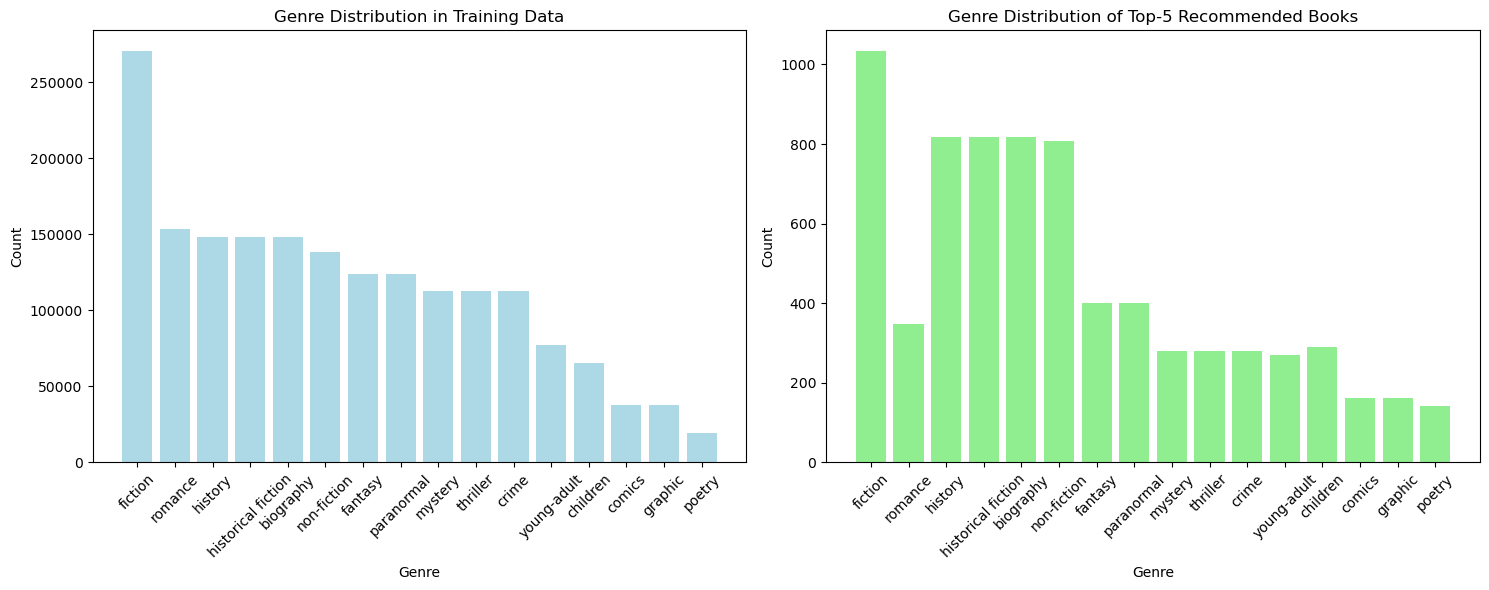

Overlap of genres: 7311
Total genres in training data (counts): 1830163
Total genres in top-5 recommendations (counts): 7311
Total unique genres in training data: 16
Total unique genres in top-5 recommendations: 16


In [91]:
genre_distribution_plot(recommendations_list, books, top_k=5)

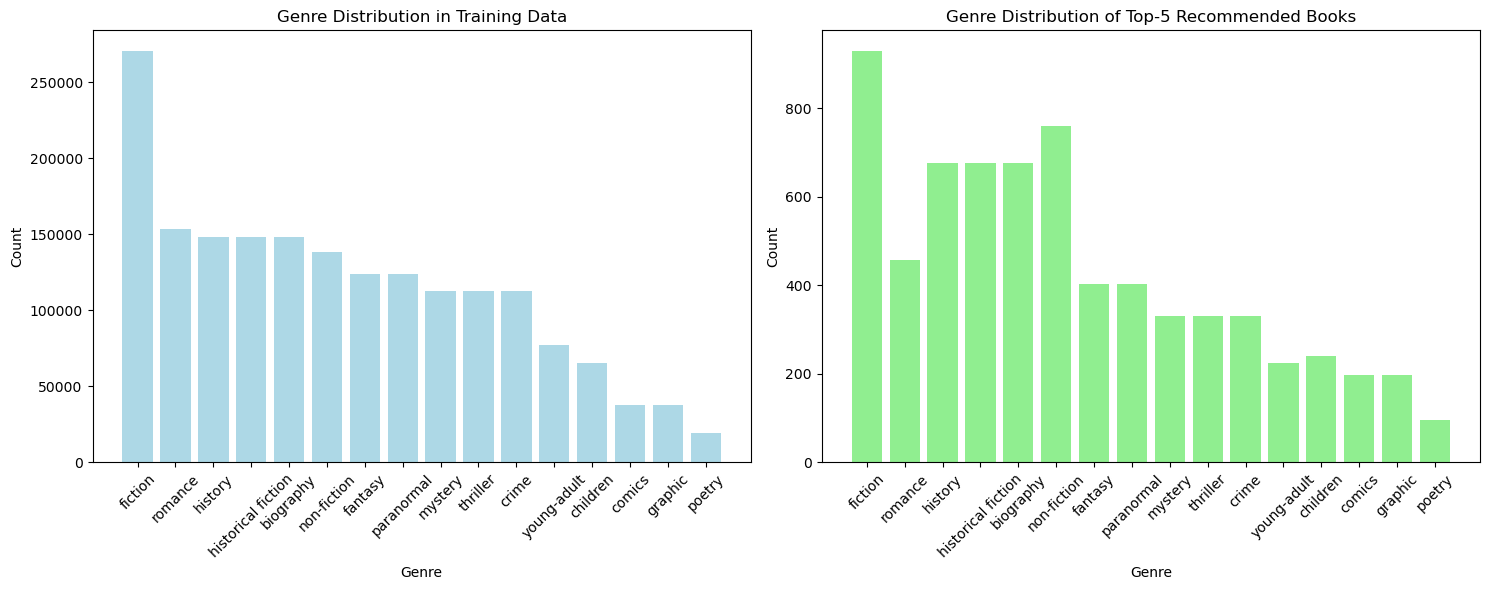

Overlap of genres: 6925
Total genres in training data (counts): 1830163
Total genres in top-5 recommendations (counts): 6925
Total unique genres in training data: 16
Total unique genres in top-5 recommendations: 16


In [ ]:
final_reorganized_data = {}

for rec in new_recs[['user_id', 'Title', 'Authors', 'Similarity Score', 'Book ID']].to_dict(orient='records'):
    rec = {k.lower(): v for k, v in rec.items()}
    rec['book_id'] = rec.pop('book id') 
    if isinstance(rec['user_id'], str) and rec['user_id'].startswith('new_user_'):
        try:
            rec['user_id'] = int(rec['user_id'].replace('new_user_', ''))
        except ValueError:
            print(f"Invalid user_id format in record: {rec}")
    if isinstance(rec['book_id'], int):
        rec['book_id'] = rec.pop('book_id')
    else:
        try:
            rec['book_id'] = int(rec['book_id'])
        except ValueError:
            print(f"Invalid book_id format in record: {rec}")
    if rec['user_id'] not in final_reorganized_data:
        final_reorganized_data[rec['user_id']] = []
    final_reorganized_data[rec['user_id']].append(rec)

final_reorganized_data_list = list(final_reorganized_data.values())

genre_distribution_plot(final_reorganized_data_list, books, top_k=5)


In [140]:
grouped_data = [
    [{'user_id': int(user_id), 'book_id': int(row['book_id'])} for _, row in group.iterrows()]
    for user_id, group in recs_nmf.groupby('user_id')
]
flattened_data = [
    [{'user_id': int(user_data[0]['user_id']), 'book_id': int(entry['book_id'])} 
     for entry in user_data] 
    for user_data in grouped_data
]

In [147]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

def genre_distribution_plot(predictions, books, top_k=5):
    # Create a dictionary of user predictions from the DataFrame
    user_predictions = {}

    # Loop through all predictions (user-item pairs)
    for _, row in predictions.iterrows():
        uid = row['user_id']
        iid = row['book_id']
        if uid not in user_predictions:
            user_predictions[uid] = []
        user_predictions[uid].append(iid)

    top_k_predictions = {}

    for uid, items in user_predictions.items():
        # Get top-k items for each user (assuming predictions are already sorted by similarity score)
        top_k_predictions[uid] = items[:top_k]

    # Genres for top-k recommended books
    predicted_book_genres = []

    # Loop through top-k recommendations
    for uid, top_items in top_k_predictions.items():
        for iid in top_items:
            book = books[books['book_id'] == iid]  # Match book ID to the books dataset
            if not book.empty:
                genres = book.iloc[0]['filtered_genres'].split(',')  # assuming comma-separated
                predicted_book_genres.extend([genre.strip() for genre in genres])

    # Count genres in top-k recommendations
    predicted_genre_counts = Counter(predicted_book_genres)

    # Get genre counts from the training data
    genre_list = []
    for genres in books['filtered_genres']:
        genre_list.extend([genre.strip() for genre in genres.split(',')])

    train_genre_counts_series = pd.Series(genre_list).value_counts()
    train_genre_counts_df = train_genre_counts_series.reset_index()
    train_genre_counts_df.columns = ['Genre', 'Count']

    # Align genres for both plots by using the training genre order
    genre_order = train_genre_counts_df['Genre'].tolist()

    # Reindex predicted genre counts to match training genre order
    predicted_genre_counts_ordered = [predicted_genre_counts.get(genre, 0) for genre in genre_order]

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Plot for training data
    ax[0].bar(genre_order, train_genre_counts_df['Count'], color='lightblue')
    ax[0].set_xlabel('Genre')
    ax[0].set_ylabel('Count')
    ax[0].set_title('Genre Distribution in Training Data')
    ax[0].tick_params(axis='x', rotation=45)

    # Plot for predicted (top-k) data
    ax[1].bar(genre_order, predicted_genre_counts_ordered, color='lightgreen')
    ax[1].set_xlabel('Genre')
    ax[1].set_ylabel('Count')
    ax[1].set_title(f'Genre Distribution of Top-{top_k} Recommended Books')
    ax[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Overlap calculation
    overlap = sum(
        min(train_genre_counts_series.get(genre, 0), predicted_genre_counts.get(genre, 0)) 
        for genre in train_genre_counts_series.index
    )
    total_train_genres = train_genre_counts_series.sum()
    total_predicted_genres = sum(predicted_genre_counts.values())

    # Count total unique genres
    unique_train_genres = train_genre_counts_series.index.nunique()
    unique_predicted_genres = len(predicted_genre_counts)

    print(f"Overlap of genres: {overlap}")
    print(f"Total genres in training data (counts): {total_train_genres}")
    print(f"Total genres in top-{top_k} recommendations (counts): {total_predicted_genres}")
    print(f"Total unique genres in training data: {unique_train_genres}")
    print(f"Total unique genres in top-{top_k} recommendations: {unique_predicted_genres}")


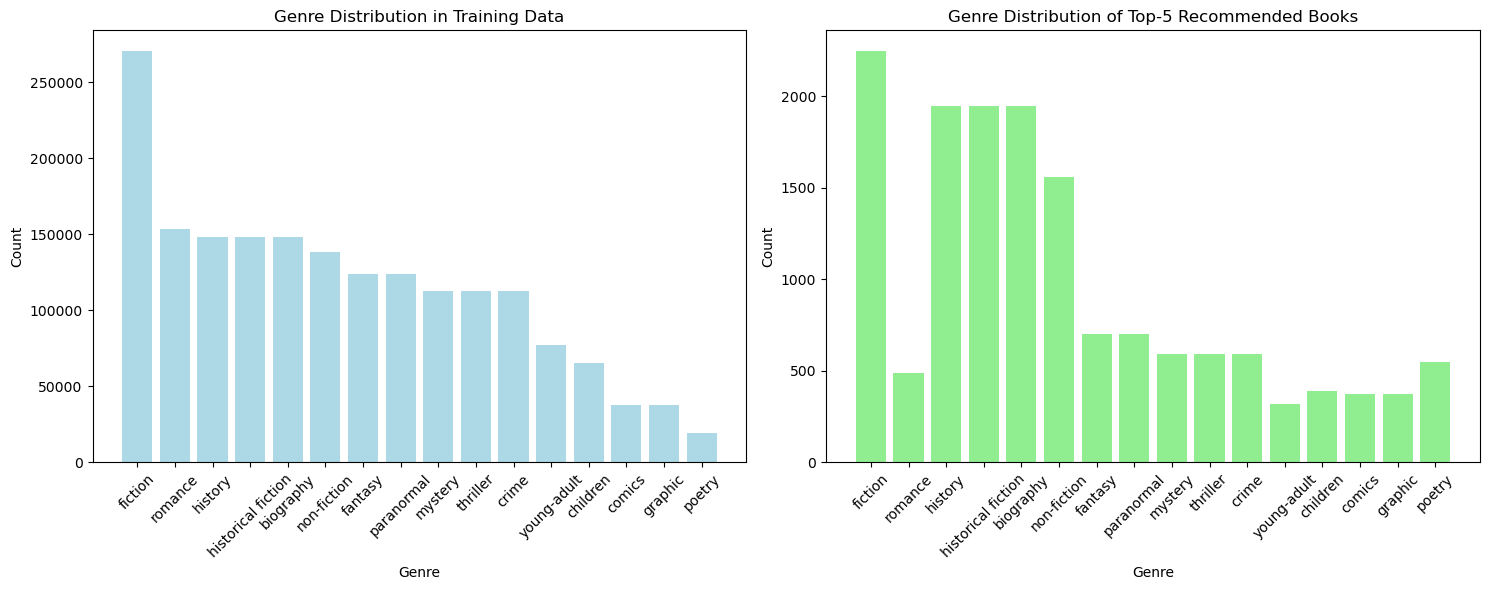

Overlap of genres: 15325
Total genres in training data (counts): 1830163
Total genres in top-5 recommendations (counts): 15325
Total unique genres in training data: 16
Total unique genres in top-5 recommendations: 16


In [152]:
genre_distribution_plot(recs_nmf, books, top_k=5)

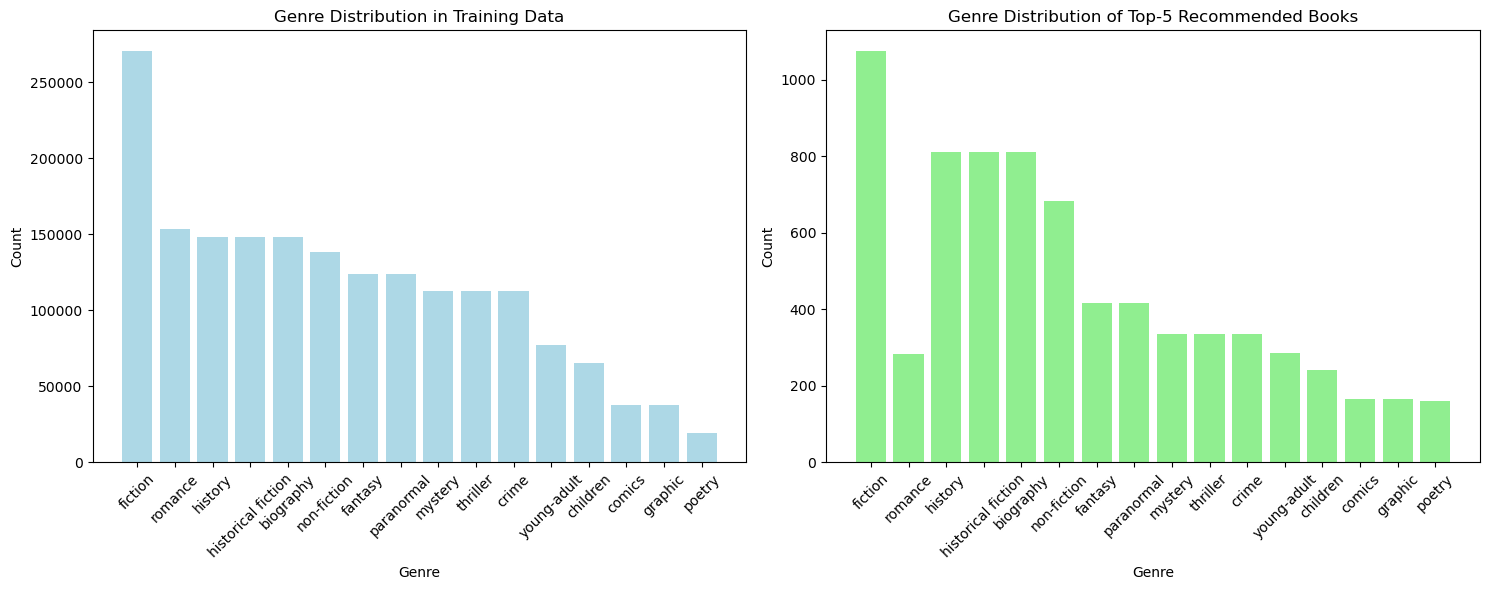

Overlap of genres: 7328
Total genres in training data (counts): 1830163
Total genres in top-5 recommendations (counts): 7328
Total unique genres in training data: 16
Total unique genres in top-5 recommendations: 16


In [153]:
genre_distribution_plot(recs_gat, books, top_k=5)

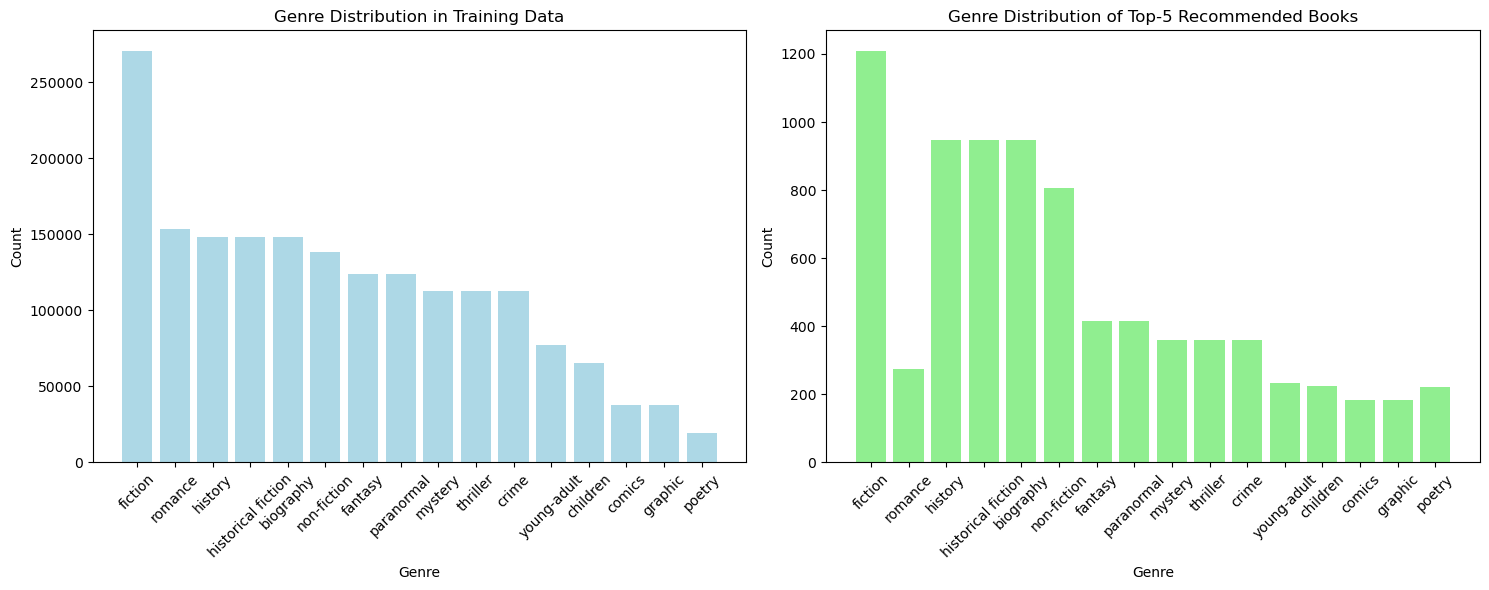

Overlap of genres: 8084
Total genres in training data (counts): 1830163
Total genres in top-5 recommendations (counts): 8084
Total unique genres in training data: 16
Total unique genres in top-5 recommendations: 16


In [154]:
genre_distribution_plot(recs_hybrid, books, top_k=5)